<div style='text-align: center;'>
<img src="images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lab Class - Week 5

## Department of Mathematics

# This Week

- Demo 5.1 European Call Option
- Demo 5.2 Analysing Errors
- Demo 5.3 Analysing Efficiency

## Law of Large Numbers

If we have a sequence of $n$ independent, identically distributed random variables $Y^i$, then we have that
$$
E[Y] = \lim_{n\to\infty} \frac{1}{n} \sum_{i=1}^n Y^i
$$
which is the law of large numbers. In other words the expectation is exactly like taking a long
run average (as we’d expect), so we can approximate the expectation 
$$
E[Y] \approx \frac{1}{n} \sum_{i=1}^n Y^i 
$$
for some finite $n$. If we call our approximation with $n$ simulations 
$$
V_n = \frac{1}{n} \sum_{i=1}^n Y^i,
$$ 
then note that $V_n$ is itself a random variable. So to generate any desired accuracy $\epsilon$, we can simply increase the value of $n$ until we almost surely have
$$
\text{Pr}\left(| V_n - E[Y] | < \epsilon \right) \to 1
$$
When applying the Monte Carlo technique in finance we are typically trying to obtain the value of $E[f(Y)]$
which is the expectation of a function of a random variable $Y$.

## Application to Options

We can't talk about using Monte-Carlo to price options without first talking about the risk-neutral measure.
If we consider $S_t$ as the value of a share price at time $t$, then the option value at expiry, $t = T$
we can think of as $V(S_T , T )$, and from the fundamental theorem of finance we know that
$$
V(S_t , t) = E_t^Q \bigg[e^{-\int_t^T r(s)ds} V (S_T , T )\bigg],
$$
or if interest rates are constant
$$
V(S_t , t) = e^{-r(T −t)} E_t^Q \bigg[V (S_T , T )\bigg],
$$
where $Q$ is the risk-neutral measure and $E_t$ denotes taking the expectation at
time $t$. Thus if we can estimate the expectation on the right hand side then we can simply
discount this value at the risk-free rate to obtain the option price today. In fact, with Monte-Carlo
methods it is also fairly straightforward to factor in stochastic interest rates as well.

Under the risk neutral measure, the standard GBM model for asset prices is written as an SDE
$$
dS_t = (r-q)S_t dt + \sigma S_t dW_t
$$
where $r$ is the risk free rate, $q$ is the dividend yield, $\sigma$ the volatility and $W_t$ a Wiener process. The objective now is to calculate the value of $S_T$ at time $T$ given some value of $S_0$ at time $t$. 
If you divide the time $t=0$ to $t=T$ into $K$ equally spaced steps, you could approximate a path followed by the asset using the relation
$$
S(t_k+\Delta t) = (r-q)S(t_k) dt + \sigma S(t_k) \sqrt{\Delta t} \phi_k
$$
where $\phi_k\sim N(0,1)$, $\Delta t = T/K$ and $t_k=k\Delta t$. This is an adapted Euler scheme, and generates ok results but is highly inefficient.

Instead, as you may have already seen, we can make use of It&ocirc;'s lemma to solve the SDE analytically, resulting in the relationship
$$
\ln S_T -\ln S_0 \sim N\bigg(\left(r-q-\frac12\sigma^2\right)T,\sigma^2 T\bigg)
$$
for the asset price at time $T$. This leads to a way to generate random value of $S_T$ without requiring us to calculate the path inbetween:
$$
S_T = S_0 \exp\left(\left(r-q-\frac12\sigma^2\right)T + \sigma \sqrt{T} \phi\right)
$$
where $\phi\sim N(0,1)$ is an iid random number from a normal distribution.

So to calculate an option price, we can write an algorithm of the form
$$
V_n = e^{-r(T −t)}\frac{1}{n} \sum_{i=1}^n V( (S_T)^i , T ),
$$
where
$$
(S_T)^i = S_0 \exp\left(\left(r-q-\frac12\sigma^2\right)T + \sigma \sqrt{T} \phi^i\right)
$$
and $\phi^i$ is a randomly simulated value from the standard normal distribution. Note as an alternative, you can just use the `lognormal` distribution from the generator.

# Demo 5.1: European Call Option

# Tasks

- Write code to generate Monte Carlo approximations to a European call option with parameters $S_0=94.68$, $T=1$, $X=100$, $r=0.05$, $q=0.02$ and $\sigma=0.4$.

Here we know the terminal condition is given by:
$$
V(S,T) = \max(S-X,0)
$$
so our psuedo algorithm will end up looking something like this:
~~~
phi = rng.normal(size=(N))
sum=0.0
for i in range(0,N)
    ST = S0 * exp( (r-q-0.5*sigma*sigma)*T + sigma*sqrt(T)*phi[i])
    VT = max(ST - X,0.0)
    sum = sum + VT
value = (sum/N) * exp(-r*T)
~~~
First import the random number library.

In [17]:
import numpy as np
rng = np.random.default_rng(seed=0) # create a random number generator and reset the starting value

Setup the parameter/variables:

In [18]:
S_0=94.68
T=1
X=100
r=0.05
q=0.02
sigma=0.4

Now generate some stock prices at time $t=T$ using the log normal distribution

In [19]:
n = 1000
ST = rng.lognormal(np.log(S_0) + (r-q-0.5*sigma*sigma)*T, sigma*np.sqrt(T), n)

Check that the output look sensible:

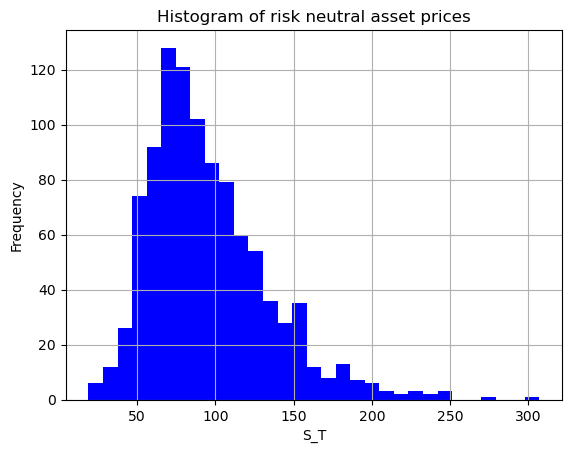

In [20]:
import matplotlib.pyplot as plt
plt.hist(ST, bins="fd", color='blue')
plt.title('Histogram of risk neutral asset prices')
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Now put this in a Monte Carlo algorithm to get

In [21]:
sum = 0.0
for i in range(0,n):
    sum += max(ST[i]-X,0.0)
value = sum/n *np.exp(-r*T)
print(" Call Option value:=",value)

 Call Option value:= 12.266180166032798


# Tasks

- code up the Monte Carlo solver into a function
- run the function several times with the same value of $n$, what do the results look like?
- run the function for different values of $n=1000,2000,...$ and plot out the results, are they what you expected? Can you identify features of the graph?

In [25]:
# Code up the Monte Carlo solver into a function
from math import exp, sqrt

def MonteCarloExpectation( N, S_0, T, X, r, q, sigma ):
    phiVals = rng.normal(size=(N))
    sum=0.0
    STvals= np.array( [S_0 * exp( (r-q-0.5*sigma*sigma)*T + sigma*sqrt(T)*phi) for phi in phiVals ] )
    VTvals = np.array( [max(ST - X,0.0) for ST in STvals] )
    sum = np.sum( VTvals )
    return (sum/N) * exp(-r*T)

# Do a small test
N = 1000
MonteCarloExpectation( N, S_0, T, X, r, q, sigma )

15.079400042623764

In [27]:
# Run the function several times with the same value of , what do the results look like?

# Generate a range of values of N and look at them
Nvals = [1000 * int(pow(2,j+1)) for j in range(10)]
Nvals

[2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000, 512000, 1024000]

In [29]:
# Run the code once for each N
findEstimate = lambda N: MonteCarloExpectation( N, S_0, T, X, r, q, sigma )
estimates = np.array( [findEstimate(N) for N in Nvals] )
estimates

array([13.72546769, 13.38166681, 13.40101933, 13.60564464, 13.9147181 ,
       13.78233843, 13.72053688, 13.70707282, 13.73097629, 13.75071123])

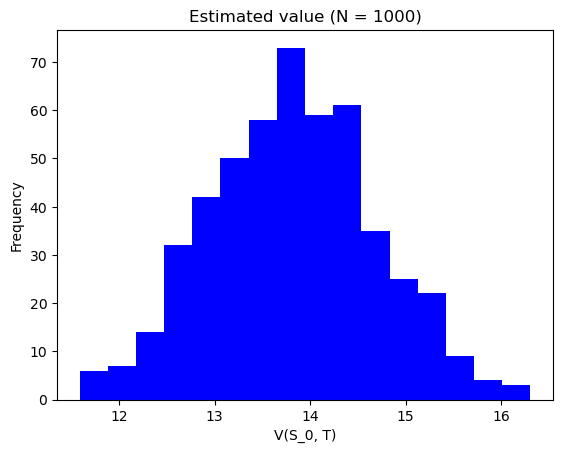

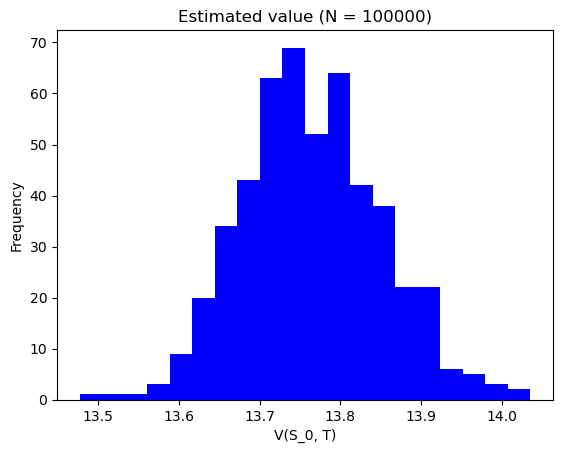

In [31]:
# Note that the values seem to settle down. We might make some histograms ...

# Get lots of values with  fixed N, then make a histogram
N = 1000
estimates = np.array([findEstimate(N) for j in range(500)])
plt.hist(estimates, bins="fd", color='blue')
plt.title(f'Estimated value (N = {N})')
plt.xlabel('V(S_0, T)')
plt.ylabel('Frequency')
plt.show()

# Get lots of values with  fixed N, then make a histogram
N = 100000
estimates = np.array([findEstimate(N) for j in range(500)])
plt.hist(estimates, bins="fd", color='blue')
plt.title(f'Estimated value (N = {N})')
plt.xlabel('V(S_0, T)')
plt.ylabel('Frequency')
plt.show()

As you'd expect, if you make your estimates based on a larger number of samples, the results have a smaller standard devaition.

# Demo 5.2: Analysing Errors

## Central limit theorem

If $V(S^T_i)$ is a sequence of independent and identically distributed random variables with mean $E_t^Q[V(S_T)]$ and variance $\eta^2$, then we can say that
$$\sqrt{n}\left(\frac{1}{n}\sum_{i=1}^nV(S_T^i)-E_t^Q[V(S_T)]\right)\xrightarrow{d} N(0,\eta^2) .$$ 
This result means that if we plot our solutions $V_n$ against $n$, we should observe our solutions converging around the mean like a normal distribution with variance $\frac{\eta^2}{n}$. In practical terms, if we draw the results on a graph, we should see approximately 70% of the results lie within one standard deviation $\frac{\eta}{\sqrt{n}}$ of the mean.
 
<div style='text-align: left;'>
<img src="images/monte-carlo-central-limit.png" alt="image" width="50%" height="auto">
</div>

Also, if $\eta$ is a known constant (and clearly this can be estimated numerically), and we generate an estimate for the true value $V_n$, we can generate any desired confidence interval to say we are $P$% confident that the solution is within the interval $[V_n-\alpha \frac{\eta}{\sqrt{n}},V_n+\alpha \frac{\eta}{\sqrt{n}}]$ for appropriate choices of $P$ and $\alpha$. For example, if $P=95$, we use $\alpha=1.96$ (or normally just $\alpha=2$ is close enough).

# Tasks

- calculate the exact value of the call option using numerical integration or the analytic formula, to be denoted $V_\text{exact}$
- estimate the value of $\eta$ for the call option, and plot the lines $$V_\text{exact}\pm\frac{\eta}{\sqrt{n}}$$ does the picture look like you would expect?
- try running the same analysis on a put option, a binary option or any other payoff. Are the results always the same?


In [32]:
# Calculate the price using numerical integraton
from scipy.integrate import quad
from scipy.stats import norm
from math import sqrt, log

# Arrange to integrate over the log-normal distrib
lnMean = log(S_0) + (r-q-0.5*sigma*sigma)*T
lnStdDev = sigma * sqrt(T)
discount = exp(-r*T)

def integrand(x):
    pdfLogX = norm.pdf(log(x), loc=lnMean, scale=lnStdDev) # normal distrib over log(x)
    pdfX = pdfLogX / x # Change-of-variable formula gives corresponding density in x-space
    return( (x - X)*discount*pdfX )

vExact = quad( integrand, X, np.inf )[0]
vExact

13.764201626260244

In [33]:
# Assemble results for a range of sample sizes
nSizes = 10 
sampleSize = [1000*int(pow(2,j+1)) for j in range(nSizes)]
sampleSize

[2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000, 512000, 1024000]

In [35]:
# Accumulate results - many at each sample size
repsPerSize=100
results = np.zeros((nSizes, repsPerSize))
for j in range(nSizes):
    N = sampleSize[j]
    for k in range(repsPerSize):
        results[j,k] = findEstimate(N) # Use our lambda function from above

# Look at a few of them    
results[0:5,0:5]                  

array([[13.54988577, 14.19592345, 13.35569305, 13.75226032, 13.67173363],
       [13.63732983, 13.5613954 , 13.37910851, 13.46034995, 13.34687589],
       [13.33542913, 13.66866229, 13.60524248, 13.80395484, 14.08122443],
       [13.42708534, 13.29342451, 14.0370355 , 14.00239254, 13.59511186],
       [13.50414667, 14.13226989, 13.90595413, 13.89098483, 13.81929842]])

In [36]:
# Estimate eta
deevs = results - vExact # differences between our estimates and true value
deevSq = np.multiply( deevs, deevs ) # elementwise product
varEstimates = np.mean( deevSq, axis=1 ) # takes means across rows

etaSqEstimates = np.multiply( varEstimates, sampleSize )
etaEstimates = np.sqrt( etaSqEstimates )
etaEstimates

array([23.11898656, 25.8352393 , 28.66322234, 30.49228901, 29.22280931,
       27.64130858, 26.21947952, 26.02422415, 32.39373717, 23.21984808])

# Demo 5.3: Evaluate the Efficiency of the Method

Here let's use the `timeit` library to get the running times for some different code. We are going to experiment with 3 different approaches to the problem, each of which should deliver broadly the same results (although this should be checked).

## Scheme 1: Euler &mdash; Maruyama Approach
1. Split $T$ into $K$ equally spaced times, with $\Delta t=\frac{T}{K}$ and $t^k = k\Delta t$.
2. Simulate $n\times K$ random increments according to $\Delta W \sim N(0,\Delta t)$
3. Create $n$ paths using the Euler-Maruyama scheme $S^{k+1} = S^{k}(1+(r-q)\Delta t + \sigma \Delta W)$ 
4. Sum up discounted payoff and take the average

## Scheme 2: Integrated Wiener Monte Carlo Approach
1. Simulate $n$ random Wiener processes according to $W_T \sim N(0,T)$
2. Calculate path using formula $S_T = S_0 \exp((r-q-\frac12\sigma^2)T + \sigma W_T)$
3. Sum up discounted payoff and take the average

## Scheme 3: Integrated Stock Path Monte Carlo Approach
1. Simulate $n$ random paths according to $\ln (S_T) \sim N(\ln(S_0)+(r-q-\frac12\sigma^2)T,\sigma^2 T)$
2. Sum up discounted payoff and take the average

In [15]:
from timeit import timeit

In [16]:
def monteCarlo1(S_0,T,X,r,q,sigma,n,K):
    dt = T/K
    dW = rng.normal(0.0,np.sqrt(dt),size=(n,K))
    sum = 0.0
    for i in range(0,n):
        St=S_0
        for k in range(0,K):
            St=St + (r-q)*St*dt + sigma*St*dW[i][k]
        sum += max(St-X,0.0)
    return sum/n *np.exp(-r*T)

In [9]:
def monteCarlo2(S_0,T,X,r,q,sigma,n):
    WT = rng.normal(0.0,np.sqrt(T), n)
    sum = 0.0
    for i in range(0,n):
        STi = S_0*np.exp((r-q-0.5*sigma*sigma)*T+sigma*WT[i])
        sum += max(STi-X,0.0)
    return sum/n *np.exp(-r*T)

In [10]:
def monteCarlo3(S_0,T,X,r,q,sigma,n):
    ST = rng.lognormal(np.log(S_0) + (r-q-0.5*sigma*sigma)*T, sigma*np.sqrt(T), n)
    sum = 0.0
    for i in range(0,n):
        sum += max(ST[i]-X,0.0)
    return sum/n *np.exp(-r*T)

# Tasks

- Plot out the results of $V_n$ vs $n$ for each of the methods (you can choose $K=100$). Are the results converging on the correct value?
- Can you generate a confidence interval for a result with $n=1000000$ paths?
- Run the code timings below -- can you explain why some codes take longer than others?
- Can you improve the run times using `numba` or `cython`?

In [12]:
n = 10000
K = 100
script="monteCarlo1(S_0,T,X,r,q,sigma,n,K)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )

print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")

Time taken to run  100  simulations with  10000  paths is 32.59096808299364  seconds.


In [14]:
n = 10000
script="monteCarlo2(S_0,T,X,r,q,sigma,n)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )

print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")

Time taken to run  100  simulations with  10000  paths is 0.8588148749986431  seconds.


In [13]:
n = 10000
script="monteCarlo3(S_0,T,X,r,q,sigma,n)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )

print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")

Time taken to run  100  simulations with  10000  paths is 0.2395697920001112  seconds.
